# Processing large datasets with Apache Spark and Amazon SageMaker

***This notebook runs on `Data Science 3.0 - Python 3` kernel on a `ml.t3.large` instance***.

Amazon SageMaker Processing Jobs are used  to analyze data and evaluate machine learning models on Amazon SageMaker. With Processing, you can use a simplified, managed experience on SageMaker to run your data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation. You can also use the Amazon SageMaker Processing APIs during the experimentation phase and after the code is deployed in production to evaluate performance.

        


![](https://docs.aws.amazon.com/images/sagemaker/latest/dg/images/Processing-1.png)

The preceding diagram shows how Amazon SageMaker spins up a Processing job. Amazon SageMaker takes your script, copies your data from Amazon Simple Storage Service (Amazon S3), and then pulls a processing container. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes. The output of the Processing job is stored in the Amazon S3 bucket you specified.

## Our workflow for processing large amounts of data with SageMaker

We can divide our workflow into two steps:
    
1. Work with a small subset of the data with Spark running in local model in a SageMaker Studio Notebook.

1. Once we are able to work with the small subset of data we can provide the same code (as a Python script rather than a series of interactive steps) to SageMaker Processing which launched a Spark cluster, runs out code and terminates the cluster.

## In this notebook...

We will analyze the `Reddit Archive` to be used for the project and then we will run a SageMaker Processing Job to filter out the comments from the subreddit 'Taylor Swift'. The filtered data will be stored in our account's s3 bucket and it is this filtered data that we will be using for our project.

## Business Goals

1. EDA: How do characteristics of Swift’s music change over time?
Business goal: Explore musical features of Swift’s music.
Technical proposal: To leverage Taylor Swift's unique music characteristics snapshot—a harmonious blend of high-energy tracks, danceable rhythms, and an infusion of joyful emotions, complemented by skillful storytelling and a versatile fusion of digital and acoustic elements. This powerful musical signature serves as a catalyst for cultivating a devoted and diverse fanbase, driving chart-topping hits, and solidifying Taylor Swift's position as a globally beloved artist across generations. 

2. EDA: What are Swift-related Reddit comments like?
Business goal: Explore Reddit comments in the r/TaylorSwift subreddit. 
Technical proposal: Flairs: Flairs are keyword tags added to a post. Clean the flair column so that similar flairs are converted to be the same, which will account for flairs that may be similar but not the same. Sum the count of flairs for each post. Show the top ten posts with the most common flairs. Create a wordcloud of the submissions’ flairs. Then, examine authors: count the number of posts written by each unique Reddit author. Find the top ten authors with the most number of posts. Finally, examine scores: sum the score (upvotes minus downvotes) for each Reddit post. Find the top ten posts with the highest scores.


3. EDA: What is public engagement with Swift-related Reddit comments and submissions over time?
Business goal: Explore engagement with Swift-related Reddit posts. 
Technical proposal: First, examine comments: in the num_comments field, find the top ten posts with the most number of comments. Create a new variable, rank_by_top_comments, that states the ranking of the post by number of comments. Then, examine the length of threads: in comments, a parent_id is the id of each comment, and a link_id is the id of each post that each comment originates from. We can calculate the number of parent_id values for each link_id, to see the most popular posts. Graph the number of comments of the top ten longest threads. 

4. EDA: What does the emotion of the song look like?
Business goal: Explore and analyze the emotions expressed in the songs.
Technical proposal: To achieve this goal, we will utilize the Spotify dataset. Specifically, we will leverage the 'energy' and 'valence' variables to calculate emotional categories, allowing us to gain insights into the emotional content of Taylor Swift's songs.

5. NLP: How does the public feel about Swift’s music?
Business goal: Analyze public sentiment towards Swift’s music. 
Technical proposal: First, clean data: lemmatize and remove stop words and special characters, and convert text data to a bag-of-words corpus using the NLTK library. Use the NLTK library to analyze sentiment of each comment. 

6. NLP: Post comment summaries
Business Goal: Build summaries of comments for each question/post.  
Technical Proposal: Using the spaCy library, we will calculate sentence importance scores and select the most important sentences. These sentences will then be joined to form summaries of each post. 

7. NLP: Named Entity Recognition
Business Goal: Identify and categorize entities mentioned in comments or submissions, such as Taylor Swift's songs or albums.
Technical Proposal: Apply NER models, like spaCy or NLTK, to recognize and categorize named entities in the text data. Specifically, look for mentions of Taylor Swift's songs, albums, or any other relevant entities.

8. NLP: Topic modeling
Business Goal: Extract the main topic of each post.  
Technical Proposal: Employ latent dirichlet allocation (LDA), a popular topic modeling technique, to model the topic of each post. First, clean data: lemmatize and remove stop words and special characters, and convert text data to a bag-of-words corpus using the NLTK library. Then, find topics in the data and specify the number of topics we want to find using the gensim library. 

9. ML: Predict danceability given album release year
Business Goal: Predict danceability given album release year to better understand trends in Taylor Swift’s music over the years. 
Technical Proposal: Use linear regression to predict danceability. 

10. ML: Predict engagement given submission 
Business Goal: Enhance user engagement in r/TaylorSwift by predicting the number of comments per submission.
Technical Proposal: Process data, split data into training and testing sets, select and train regression models, evaluate the model's performance with metrics like MAE, MSE, and R^2, assess feature importance, interpret and visualize results, deploy the model for real-time predictions, and establishing a feedback loop for continuous data collection and model retraining. This approach provides a comprehensive plan for the r/TaylorSwift subreddit to predict and understand user engagement dynamics.

11. ML: Predict song popularity
Business Goal: Focusing on Taylor Swift's music, establish a threshold based on Spotify streaming counts, integrating external and Reddit data, extracting features, labeling songs, training a classification model, evaluating performance, and enabling real-time predictions with continuous model updates for relevance
Technical Proposal: This project entails data collection from both Spotify API and Reddit subreddits, followed by data preprocessing and feature extraction. NER models are used to identify relevant entities in comments. The data is labeled according to the established popularity threshold, and a classification model is chosen and trained using the extracted features. Model performance is evaluated using classification metrics, and feature importance analysis is conducted.


## Link to external website

Website Link: https://gu-dsan6000.github.io/fall-2023-reddit-project-team-21/

## Setup
We need an available Java installation to run pyspark. The easiest way to do this is to install JDK and set the proper paths using conda

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [4]:
!pip install altair
!pip install wordcloud

  Obtaining dependency information for altair from https://files.pythonhosted.org/packages/c5/e4/7fcceef127badbb0d644d730d992410e4f3799b295c9964a172f92a469c7/altair-5.2.0-py3-none-any.whl.metadata
  Using cached altair-5.2.0-py3-none-any.whl.metadata (8.7 kB)
Using cached altair-5.2.0-py3-none-any.whl (996 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/22/0d/bb4eccd60d272b33cbc79c661c60acc604f1688cfc922deb9d3eb5be640a/wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
Using cached wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (455 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Load required libraries

In [5]:
# Pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# General
import pandas as pd
import numpy as np
import json

# Visualizations
import matplotlib.pyplot as plt
import altair as alt
import plotly.graph_objects as go
import wordcloud
import plotly.express as px
import plotly.io as pio
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from pyspark.ml.feature import StopWordsRemover

# Word embedding
import gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
pd.set_option('display.max_colwidth', None)

## Build spark session

In [7]:
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0f9f1615-3954-4925-aa9b-f26c57f8427a;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 320ms :: artifacts dl 21ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


## Reading data into a Spark Dataframe

Note that we will be using the "s3a" adapter. S3A enables Hadoop to directly read and write Amazon S3 objects.

Let us read data from the s3 path where we saved the filtered data.

In [8]:
%%time

# Bucket name
bucket_name = 'cs20461'

# Specify the path with a wildcard (*) to read all Parquet files
# Path to read the entire data
s3_comments_path = f"s3a://{bucket_name}/tswiftComments/part-*.snappy.parquet"

# Path to read the subset of the data
# s3_path = f"s3a://{bucket_name}/tswiftComments/ts_comm_small/part-*.snappy.parquet"

# Read all parquet files and concatenate them
ts_comm_all = spark.read.parquet(s3_comments_path, header=True)
ts_count = ts_comm_all.count()
print(f'Number of rows in dataset: {ts_count}')
print(f'Number of columns in dataset: {len(ts_comm_all.columns)}')

23/11/29 18:53:13 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


Number of rows in dataset: 1974887
Number of columns in dataset: 21
CPU times: user 24.1 ms, sys: 7.85 ms, total: 32 ms
Wall time: 32.3 s


Lets take a look at how the data has been structured

In [9]:
# Use the printSchema method to print the Spark DataFrame schema
ts_comm_all.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



### Dataset overview

Lets take a look at the data by selecting a subset of columns and using .show() method for displaying.

In [10]:
# display a subset of columns
ts_comm_all.select("subreddit", "author", "body", "parent_id", "link_id", "id", "created_utc").show()

+-----------+--------------------+--------------------+----------+---------+-------+-------------------+
|  subreddit|              author|                body| parent_id|  link_id|     id|        created_utc|
+-----------+--------------------+--------------------+----------+---------+-------+-------------------+
|TaylorSwift|      realscoutfinch|This this this! I...|t1_iracq55|t3_xwui3g|irf7cfk|2022-10-07 16:46:13|
|TaylorSwift|         dietrichs90|Taylors caption t...| t3_xt3tob|t3_xt3tob|irf7gn3|2022-10-07 16:47:05|
|TaylorSwift|        evergreenkat|The whole left co...| t3_xxy08f|t3_xxy08f|irf7jgy|2022-10-07 16:47:40|
|TaylorSwift|         sapphicsato|IWAASPIWTWWGROMBF...| t3_xxr3aj|t3_xxr3aj|irf7qr0|2022-10-07 16:49:08|
|TaylorSwift|           [deleted]|           [deleted]| t3_xt3tob|t3_xt3tob|irf7rn4|2022-10-07 16:49:19|
|TaylorSwift|        hannahberrie|               Whelp|t1_irc8u25|t3_xtuyhw|irf7uk8|2022-10-07 16:49:54|
|TaylorSwift|       AutoModerator|**All posts are a...|

# Data Quality Checks

This section will involve basic data preprocessing steps like data cleaning, munging and creation of possible features that might help in our analysis later on.

### Check for missing values

The initial step in data preprocessing involves identifying and handling missing values. Let's begin by counting the missing values and visualizing them to gain a better understanding.

In [11]:
# Calculating null and Nan values in all the columns and comparing the % to the total count of rows

# Selecting relevant columns and calculating null values
null_values_s = ts_comm_all.select(*[
    (
        # If the data type is not boolean, timestamp, or date
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) 
        if t not in ("boolean", "timestamp", "date") 
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in ts_comm_all.dtypes if c in ts_comm_all.columns
]).toPandas()

# Reshaping the dataframe for better visualization
null_values = pd.melt(null_values_s)

# Adding total count and percentage of null values
null_values['total_value'] = ts_count
null_values['percent_null'] = round(null_values['value'] / null_values['total_value'], 2)*100

In [12]:
# Sorting the DataFrame 'null_values' based on the 'percent_null' column in descending order
null_values = null_values.sort_values(by='percent_null', ascending=False)

# Displaying the sorted DataFrame
null_values

,variable,value,total_value,percent_null
1,author_cakeday,1968363,1974887,100.0
8,distinguished,1925794,1974887,98.0
2,author_flair_css_class,1225555,1974887,62.0
3,author_flair_text,1155536,1974887,59.0
16,retrieved_on,237757,1974887,12.0
4,body,0,1974887,0.0
0,author,0,1974887,0.0
6,controversiality,0,1974887,0.0
5,can_gild,0,1974887,0.0
9,edited,0,1974887,0.0


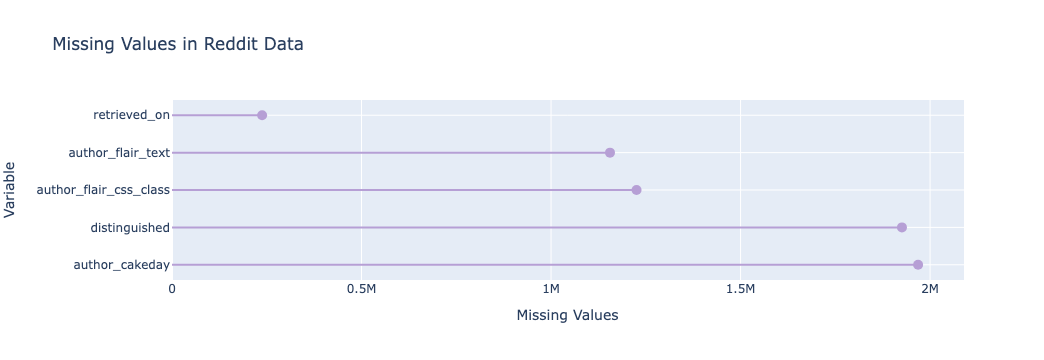

In [14]:
# Filter the dataset to select columns with null values
columns_with_null = null_values[null_values['value'] > 0]

# Create a lollipop plot using Plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=columns_with_null['value'],
        y=columns_with_null['variable'],
        mode='markers',
        marker=dict(size=10, color='#b69fd5'),
        text=columns_with_null['value'],
    )
)

# Add vertical lines (lollipop sticks)
shapes = []
for _, row in columns_with_null.iterrows():
    shapes.append(
        dict(
            type="line",
            xref="x",
            yref="y",
            x0=0,  # x-coordinate at 0
            x1=row['value'],  # x-coordinate at the number of missing values
            y0=row['variable'],  # y-coordinate at the variable name
            y1=row['variable'],  # y-coordinate at the variable name
            line=dict(color="#b69fd5", width=2),  # Line color and width
        )
    )

fig.update_layout(
    title="Missing Values in Reddit Data",
    xaxis_title="Missing Values",
    yaxis_title="Variable",
    showlegend=False,
    shapes=shapes,  # Add the 'shapes' attribute to draw lines
)

fig.show()

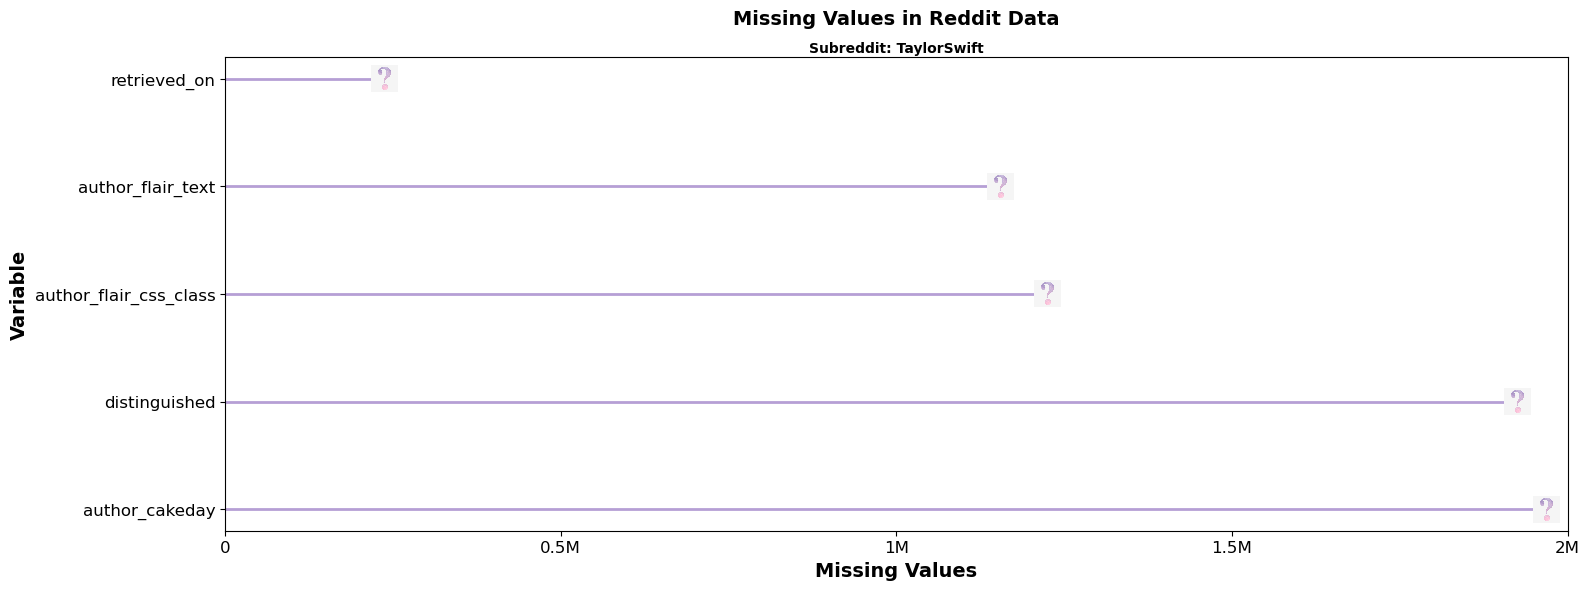

In [53]:
# Filter the dataset to select columns with null values
columns_with_null = null_values[null_values['value'] > 0]

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(16, 6))

# Create horizontal line plot for missing values
ax.hlines(
    y=columns_with_null['variable'],  
    xmin=0,  
    xmax=columns_with_null['value'],  
    color='#b69fd5',  
    linewidth=2,  
)

# Define the smaller zoom factor for the lollipop stick images
small_zoom = 0.03

# Add lollipop stick images
for index, row in columns_with_null.iterrows():
    stick_image = plt.imread('../plots/img/questionmark.jpeg')  
    stick_imagebox = OffsetImage(stick_image, zoom=small_zoom)
    ab = AnnotationBbox(
        stick_imagebox,
        (row['value'], row['variable']),  
        frameon=False,
    )
    ax.add_artist(ab)

# Change the axis labels
ax.set_ylabel('Variable', fontsize=14, fontweight='bold')
ax.set_xlabel('Missing Values', fontsize=14, fontweight='bold')

# Change the x ticks
custom_xticks = [0, 0.5e6, 1e6, 1.5e6, 2e6]
custom_xlabels = ['0', '0.5M', '1M', '1.5M', '2M']
ax.set_xticks(custom_xticks)
ax.set_xticklabels(custom_xlabels, fontsize=12)

# Set X-axis limits to start from 0
ax.set_xlim(0, max(custom_xticks))

# Title and subtitle with bold and adjusted font sizes
title = "Missing Values in Reddit Data"
subtitle = "Subreddit: TaylorSwift"
ax.text(0.5, 1.07, title, transform=ax.transAxes, fontsize=14, fontweight='bold', ha='center')
ax.text(0.5, 1.01, subtitle, transform=ax.transAxes, fontsize=10, fontweight='bold', ha='center')

# Increase tick size for y-axis
ax.tick_params(axis='y', which='both', labelsize=12)

# Save the plot as a PNG image
plt.tight_layout()
plt.savefig('../plots/nullValuesChart.png', dpi=300)  
plt.show()

### Handling Missing Values in Big Data: Making Informed Decisions

From the visual analysis of missing values, it's evident that certain columns, such as 'author_flair_css_class' and 'author_flair_text', have a significant number of missing values. However, in the context of big data, dropping these columns outright might not be the most prudent decision.

#### Consideration for 'author_flair_css_class' and 'author_flair_text'

Despite having more than a million missing values in these columns, there are still 700-800k values present. Instead of indiscriminately dropping these columns, we propose a nuanced approach:

1. **Subset Creation:**
    - Create two subsets of the dataset:
        - Subset 1: Includes the columns 'author_flair_css_class' and 'author_flair_text'.
        - Subset 2: Excludes the columns 'author_flair_css_class' and 'author_flair_text'.

2. **Further Analysis:**
    - Perform in-depth analysis on both subsets to understand the impact on downstream tasks.
    - Evaluate whether the columns 'author_flair_css_class' and 'author_flair_text' significantly affect the overall analysis.

This approach allows for a more context-aware handling of missing values, considering the scale and nature of big data, and ensures that valuable information is not discarded hastily.


In [24]:
# Columns to be dropped
drop_cols = ("author_cakeday", "author_flair_css_class", "distinguished")

# Creating a new DataFrame without the specified columns
ts_comm = ts_comm_all.drop(*drop_cols)

# Display the schema
ts_comm.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



Lets inspect the 'body' column of our dataset which contains the most significant information i.e the comments of the subreddit.

There are some deleted comments contained within the dataset - they don't contain any information that can be used for NLP purposes - and therefore should be deleted.

In [25]:
# Drop deleted posts, then show updated rows count
ts_comm = ts_comm.filter((ts_comm.body != "[deleted]") & (ts_comm.body != "[removed]"))

# Show updated counts - (Rows, Columns)
print(f'Number of rows: {ts_comm.count()}, Columns: {len(ts_comm.columns)}')

Number of rows: 1844442, Columns: 18


For the final check, lets verify the length of each comment in the body column

In [26]:
# Adding a new column 'length_body' to the DataFrame, representing the length of the 'body' column
ts_comm = ts_comm.withColumn("length_body", F.length(ts_comm.body))

# Ordering the DataFrame by 'length_body' in descending order and selecting the 'length_body' column
ts_comm.orderBy(ts_comm['length_body'].desc()).select(ts_comm.length_body).show(10)  # Displaying the top 10 rows

+-----------+
|length_body|
+-----------+
|       9956|
|       9949|
|       9899|
|       9852|
|       9842|
|       9747|
|       9713|
|       9263|
|       9125|
|       9111|
+-----------+
only showing top 10 rows



In [99]:
# Ordering the DataFrame by 'length_body' in ascending order and selecting the 'length_body' column
ts_comm.orderBy(ts_comm['length_body'].asc()).select(ts_comm.length_body).show(10) # Displaying the top 10 rows

+-----------+
|length_body|
+-----------+
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          0|
|          1|
|          1|
|          1|
+-----------+
only showing top 10 rows



Upon examining the top 10 maximum and minimum values for the length of the comment body, none of the rows have a body length of zero.

As a sanity check, we inspect the content because as a zero-length body implies the absence of text, and consequently, no actual comment.

In [27]:
# Displaying the rows where the length of the 'body' column is 0
ts_comm.filter(ts_comm['length_body'] == 0).select(ts_comm.body).show()

+----+
|body|
+----+
|    |
|    |
|    |
|    |
|    |
|    |
|    |
+----+



We will filter our dataset to remove these empty comments.

In [28]:
ts_comm = ts_comm.filter(ts_comm['length_body'] > 0)

In [29]:
# SANITY CHECK
ts_comm.count()

1844435

In [30]:
# Use the printSchema method to print the Spark DataFrame schema
ts_comm.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- length_body: integer (nullable = true)



## Introducing flairs dataset

The initial comments dataset contained many comments that lacked flairs. As flairs are a common way to communicate a comment's topic on reddit, we decided to create a subset of data containing only comments that contained flairs. This will allow for the following analysis

1. **Further Analysis:**
    - How flairs are used when communicating on reddit posts on r/TaylorSwift
    - Evaluate whether having only flaired comments significantly affect the overall analysis.

Flairs is a subset of the comments data that ONLY has posts with flairs - check data-cleaning-notebook.ipynb for more information on how this was obtained.

The flairs dataset is the one which was mentioned earlier. This dataset has been formed keeping in mind that every possible value of flair is present.

In [31]:
# for flairs
s3_flairs_path = f"s3a://{bucket_name}/finalProjectData/flairedComments/part-*.snappy.parquet"

# Read in the comments and flairs data from r/TaylorSwift
flairs = spark.read.parquet(s3_flairs_path, header=True) 
ts_flairs_count = flairs.count()
print(f'Number of rows in flairs dataset: {ts_flairs_count}')
print(f'Number of columns in dataset: {len(flairs.columns)}')

Number of rows in flairs dataset: 749332
Number of columns in dataset: 18


In [32]:
flairs.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [33]:
# Show subset of interesting columns
flairs.select("subreddit", "author", "id", "body", "created_utc").show()

+-----------+-------------------+-------+--------------------+-------------------+
|  subreddit|             author|     id|                body|        created_utc|
+-----------+-------------------+-------+--------------------+-------------------+
|TaylorSwift|     realscoutfinch|irf7cfk|This this this! I...|2022-10-07 16:46:13|
|TaylorSwift|        dietrichs90|irf7gn3|Taylors caption t...|2022-10-07 16:47:05|
|TaylorSwift|        sapphicsato|irf7qr0|IWAASPIWTWWGROMBF...|2022-10-07 16:49:08|
|TaylorSwift|       hannahberrie|irf7uk8|               Whelp|2022-10-07 16:49:54|
|TaylorSwift|             vlarek|irf8464|Grey's aired last...|2022-10-07 16:51:53|
|TaylorSwift|        robynnc1290|irf86gd|I think there’s s...|2022-10-07 16:52:22|
|TaylorSwift|       indievibes23|irf8ijo|I’M SO EXCITED! I...|2022-10-07 16:54:52|
|TaylorSwift|        dietrichs90|irf8r17|                Oh😂|2022-10-07 16:56:39|
|TaylorSwift|        dietrichs90|irf8zm5|        It has to be|2022-10-07 16:58:25|
|Tayl

In [34]:
# Check the number of missing values in each column - credit to https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
flairs.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in flairs.columns]).show()

+------+----------------------+----+--------+----------------+-----------+------+------+---+------------+-------+---------+---------+------------+-----+--------+---------+------------+
|author|author_flair_css_class|body|can_gild|controversiality|created_utc|edited|gilded| id|is_submitter|link_id|parent_id|permalink|retrieved_on|score|stickied|subreddit|subreddit_id|
+------+----------------------+----+--------+----------------+-----------+------+------+---+------------+-------+---------+---------+------------+-----+--------+---------+------------+
|     0|                     0|   0|       0|               0|          0|     0|     0|  0|           0|      0|        0|        0|      108249|    0|       0|        0|           0|
+------+----------------------+----+--------+----------------+-----------+------+------+---+------------+-------+---------+---------+------------+-----+--------+---------+------------+



So only 'retrieved_on' column has missing values in the flairs dataset. This column has the information when the comment was crawled. Hence there is no way to impute the missing values. Therefore, we will move forward to drop it.

In [36]:
# Creating a new DataFrame without the specified columns
flairs = flairs.drop("retrieved_on")

# Displaying the schema of the new DataFrame
flairs.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



## Exporting Cleaned Datasets to Amazon S3

Now that the datasets have been thoroughly cleaned and preprocessed, it's a good practice to store them in our Amazon S3 buckets. This ensures that the cleaned datasets are easily accessible for future analyses without the need to repeat the cleaning process.


### Comments dataset

In [30]:
# Write out the cleaned flairs dataset to a parquet file
# ts_comm.write.parquet("s3a://cs20461/finalProjectData/cleanedData/")

### Comments subset data

In [32]:
# # Subset the data
# ts_comm_small = ts_comm.sample(
#     fraction = 0.01, withReplacement=False
# )

# ts_comm_small.count()

18370

In [33]:
# # Write out the cleaned comments dataset to a parquet file
# ts_comm_small.write.parquet("s3a://cs20461/finalProjectData/cleanedData/cleanSubset/")

In [34]:
# # Copy the files to Cynthia's, Michael's, and Chaitanya's s3 buckets
# !aws s3 cp s3://rs2190-labdata/finalProjectData/cleanedData/ s3://cn524-labdata/finalProjectData/cleanedData/ --recursive
# !aws s3 cp s3://rs2190-labdata/finalProjectData/cleanedData/ s3://mjv38-labdata/finalProjectData/cleanedData/ --recursive
# !aws s3 cp s3://rs2190-labdata/finalProjectData/cleanedData/ s3://cs2046-labdata/finalProjectData/cleanedData/ --recursive

copy: s3://rs2190-labdata/finalProjectData/cleanedData/cleanSubset/_SUCCESS to s3://cn524-labdata/finalProjectData/cleanedData/cleanSubset/_SUCCESS
copy: s3://rs2190-labdata/finalProjectData/cleanedData/_SUCCESS to s3://cn524-labdata/finalProjectData/cleanedData/_SUCCESS
copy: s3://rs2190-labdata/finalProjectData/cleanedData/cleanSubset/part-00000-c6305c71-0c48-4391-993f-7a488690129c-c000.snappy.parquet to s3://cn524-labdata/finalProjectData/cleanedData/cleanSubset/part-00000-c6305c71-0c48-4391-993f-7a488690129c-c000.snappy.parquet
copy: s3://rs2190-labdata/finalProjectData/cleanedData/cleanSubset/part-00006-c6305c71-0c48-4391-993f-7a488690129c-c000.snappy.parquet to s3://cn524-labdata/finalProjectData/cleanedData/cleanSubset/part-00006-c6305c71-0c48-4391-993f-7a488690129c-c000.snappy.parquet
copy: s3://rs2190-labdata/finalProjectData/cleanedData/cleanSubset/part-00008-c6305c71-0c48-4391-993f-7a488690129c-c000.snappy.parquet to s3://cn524-labdata/finalProjectData/cleanedData/cleanSubse

### Flairs dataset

In [40]:
# Write out the cleaned flairs dataset to a parquet file
# flairs.write.parquet("s3a://cs20461/finalProjectData/cleanedFlairs/")

### Flairs subset data

In [41]:
# # Subset the data
# flairs_small = flairs.sample(
#     fraction = 0.01, withReplacement=False
# )

# flairs_small.count()

7603

In [42]:
# Write out the cleaned comments dataset to a parquet file
# flairs_small.write.parquet("s3a://cs20461/finalProjectData/cleanedFlairs/cleanSubset/")

In [43]:
# # Copy the files to Cynthia's, Michael's, and Chaitanya's s3 buckets
# !aws s3 cp s3://rs2190-labdata/finalProjectData/cleanedFlairs/ s3://cn524-labdata/finalProjectData/cleanedFlairs/ --recursive
# !aws s3 cp s3://rs2190-labdata/finalProjectData/cleanedFlairs/ s3://mjv38-labdata/finalProjectData/cleanedFlairs/ --recursive
# !aws s3 cp s3://rs2190-labdata/finalProjectData/cleanedFlairs/ s3://cs2046-labdata/finalProjectData/cleanedFlairs/ --recursive

copy: s3://rs2190-labdata/finalProjectData/cleanedFlairs/cleanSubset/_SUCCESS to s3://cn524-labdata/finalProjectData/cleanedFlairs/cleanSubset/_SUCCESS
copy: s3://rs2190-labdata/finalProjectData/cleanedFlairs/_SUCCESS to s3://cn524-labdata/finalProjectData/cleanedFlairs/_SUCCESS
copy: s3://rs2190-labdata/finalProjectData/cleanedFlairs/cleanSubset/part-00001-c7810f12-7aee-438a-a929-7331b07019b1-c000.snappy.parquet to s3://cn524-labdata/finalProjectData/cleanedFlairs/cleanSubset/part-00001-c7810f12-7aee-438a-a929-7331b07019b1-c000.snappy.parquet
copy: s3://rs2190-labdata/finalProjectData/cleanedFlairs/cleanSubset/part-00000-c7810f12-7aee-438a-a929-7331b07019b1-c000.snappy.parquet to s3://cn524-labdata/finalProjectData/cleanedFlairs/cleanSubset/part-00000-c7810f12-7aee-438a-a929-7331b07019b1-c000.snappy.parquet
copy: s3://rs2190-labdata/finalProjectData/cleanedFlairs/part-00000-b8cdf0ad-0498-4e23-9f5f-aad6cdcc0003-c000.snappy.parquet to s3://cn524-labdata/finalProjectData/cleanedFlairs/pa

### Sanity check

We have to verify if the data has been copied to other s3 buckets after enabling cross-sharing.

In [47]:
# !aws s3 ls s3://cs2046-labdata/finalProjectData/

                           PRE cleanedComments/
                           PRE cleanedData/
                           PRE cleanedFlairs/
                           PRE flairedComments/
                           PRE flairedCommentsSubset/


## Data Transformation

To calculate the age of each comment, we can subtract the creation timestamp `created_utc` from the current timestamp `retrieved_on`. This will give us the time duration since the comment was created. Analyzing comment scores in relation to their age can provide insights into the dynamics of community engagement over time.

We'll use this age information in subsequent analyses to explore patterns and trends related to comment scores.

In [37]:
ts_with_date = ts_comm.withColumn("comment_age", F.datediff(F.col("retrieved_on"),F.col("created_utc")))

ts_with_date.select(ts_with_date.created_utc,\
                        ts_with_date.retrieved_on,\
                        ts_with_date.comment_age).show(5)

+-------------------+-------------------+-----------+
|        created_utc|       retrieved_on|comment_age|
+-------------------+-------------------+-----------+
|2022-10-07 16:46:13|2022-11-09 07:56:30|         33|
|2022-10-07 16:47:05|2022-11-09 07:56:27|         33|
|2022-10-07 16:47:40|2022-11-09 07:56:25|         33|
|2022-10-07 16:49:08|2022-11-09 07:56:18|         33|
|2022-10-07 16:49:54|2022-11-09 07:56:16|         33|
+-------------------+-------------------+-----------+
only showing top 5 rows



We have added features like is_weekend, hour_post, month_post, and year_post to our dataset, which will aid in analyzing the activity pattern during different times. The is_weekend variable indicates whether a post/comment was made on a weekend, and hour_post, month_post, and year_post represent the hour, month, and year of the post/comment, respectively. These features will be valuable for visualizing and understanding the temporal aspects of Reddit engagement.

In [38]:
# Extracting additional temporal features
# Weekend or not
ts_with_date = ts_with_date.withColumn("is_weekend", F.dayofweek("created_utc").isin([1, 7]).cast("int"))
# Hour
ts_with_date = ts_with_date.withColumn("hour_post", F.hour("created_utc"))
# Day
ts_with_date = ts_with_date.withColumn("day_post", F.dayofmonth("created_utc"))
# Month
ts_with_date = ts_with_date.withColumn("month_post", F.month("created_utc"))
# Year
ts_with_date = ts_with_date.withColumn("year_post", F.year("created_utc"))

# Displaying the top 5 rows with the new temporal features
ts_with_date.select(ts_with_date.created_utc, ts_with_date.year_post, ts_with_date.month_post, ts_with_date.day_post, ts_with_date.hour_post, ts_with_date.is_weekend).show(5)

+-------------------+---------+----------+--------+---------+----------+
|        created_utc|year_post|month_post|day_post|hour_post|is_weekend|
+-------------------+---------+----------+--------+---------+----------+
|2022-10-07 16:46:13|     2022|        10|       7|       16|         0|
|2022-10-07 16:47:05|     2022|        10|       7|       16|         0|
|2022-10-07 16:47:40|     2022|        10|       7|       16|         0|
|2022-10-07 16:49:08|     2022|        10|       7|       16|         0|
|2022-10-07 16:49:54|     2022|        10|       7|       16|         0|
+-------------------+---------+----------+--------+---------+----------+
only showing top 5 rows



We have extracted the date from the `created_utc` column, creating new variables that represent the date. These new variables will be instrumental in our subsequent analyses, particularly in visualizations and understanding the patterns of both submissions posted and comments under those submissions. By leveraging these variables, we aim to gain clearer insights into our business goals.

In [39]:
# Submissions
submissions_posted = ts_with_date.select("created_utc")

# Convert the 'created_utc' column to a DateType
submissions_posted = submissions_posted.withColumn("date", F.to_date("created_utc"))
# Drop nan values
submissions_posted = submissions_posted.dropna()

# Group by date column and aggregate
submissions_posted_df= submissions_posted.groupBy("date").agg(F.count("date").alias('submissions_count'))
# Convert to a pandas dataframe
submissions_posted_df_pd = submissions_posted_df.toPandas()

# Sort the DataFrame by the "date" column
submissions_posted_df_pd = submissions_posted_df_pd.sort_values(by='date').reset_index()
# Drop redundant columns
submissions_posted_df_pd.drop(columns = ['index'], inplace= True)
submissions_posted_df_pd

,date,submissions_count
0,2021-01-01,1046
1,2021-01-02,845
2,2021-01-03,1043
3,2021-01-04,1112
4,2021-01-05,1058
...,...,...
814,2023-03-27,4141
815,2023-03-28,3880
816,2023-03-29,3707
817,2023-03-30,4860


In [40]:
# Comments
comments_crawled = ts_with_date.select("retrieved_on")

# Convert the 'created_utc' column to a DateType
comments_crawled = comments_crawled.withColumn("date", F.to_date("retrieved_on"))
# Drop nan values
comments_crawled = comments_crawled.dropna()

# Group by date column and aggregate
comments_crawled_df= comments_crawled.groupBy("date").agg(F.count("date").alias('comments_count'))
# Convert to a pandas dataframe
comments_crawled_df_pd = comments_crawled_df.toPandas()

# Sort the DataFrame by the "combined" column
comments_crawled_df_pd = comments_crawled_df_pd.sort_values(by='date').reset_index()
# Drop redundant columns
comments_crawled_df_pd.drop(columns = ['index'], inplace= True)
comments_crawled_df_pd

,date,comments_count
0,2021-05-04,281
1,2021-05-05,1104
2,2021-05-06,1090
3,2021-05-07,1323
4,2021-05-08,1331
...,...,...
100,2023-03-07,30848
101,2023-03-08,25962
102,2023-04-10,6386
103,2023-04-11,90266


## Data summary tables

We calculated the hourly activity on both weekdays and weekends, and then merged the two DataFrames to calculate the average activity. 

The below code essentially calculates the average hourly activity, categorizing weekdays and weekends, and presents the results in a a summary table named hourly_activity_df.

In [41]:
# Adding a column 'body_count' with a constant value of 1 to represent each comment
ts_with_date = ts_with_date.withColumn("body_count", F.lit(1))

# Grouping by the hour and calculating the sum of 'body_count' to get hourly activity
hourly_activity_table = ts_with_date.groupBy("hour_post").agg(F.sum("body_count").alias('Activity'))
hourly_activity_sum = hourly_activity_table.toPandas()

# Grouping by both 'hour_post' and 'is_weekend', then calculating the sum of 'body_count'
hourly_activity_table_weekend = ts_with_date.groupBy("hour_post", "is_weekend").agg(F.sum("body_count").alias('Activity'))
hourly_activity_df = hourly_activity_table_weekend.toPandas()

# Merging the DataFrames to get the total activity and calculating average activity
hourly_activity_df = pd.merge(hourly_activity_df, hourly_activity_sum, on='hour_post', how='inner')
hourly_activity_df['avg_activity'] = hourly_activity_df['Activity_x'] / hourly_activity_df['Activity_y']

# Adding a column 'division' with values 5 for weekdays and 2 for weekends
hourly_activity_df['division'] = np.select(
    [(hourly_activity_df['is_weekend'] == 0)], [5], 
    default=2
)

# Adding a column 'weekend' to categorize as 'Weekday' or 'Weekend'
hourly_activity_df['weekend'] = np.select(
    [(hourly_activity_df['is_weekend'] == 0)], ["Weekday"], 
    default="Weekend"
)

# Calculating the final average activity by dividing 'Activity_x' by 'division'
hourly_activity_df['avg_activity'] = hourly_activity_df['Activity_x'] / hourly_activity_df['division']

# Displaying the resulting DataFrame
hourly_activity_df

,hour_post,is_weekend,Activity_x,Activity_y,avg_activity,division,weekend
0,17,1,21809,102442,10904.5,2,Weekend
1,17,0,80633,102442,16126.6,5,Weekday
2,1,0,69520,91744,13904.0,5,Weekday
3,1,1,22224,91744,11112.0,2,Weekend
4,6,1,15041,52842,7520.5,2,Weekend
5,6,0,37801,52842,7560.2,5,Weekday
6,3,1,22527,90354,11263.5,2,Weekend
7,3,0,67827,90354,13565.4,5,Weekday
8,18,1,21361,104190,10680.5,2,Weekend
9,18,0,82829,104190,16565.8,5,Weekday


In [54]:
hourly_activity_df.to_csv('../data/csv/hourly_activity_df.csv', index = False)

The above summary table offers insights into the activity trends during weekdays and weekends, considering different hours of the day. Let's break down the columns:

- **hour_post:** Indicates the specific hour when the activity took place.
- **is_weekend:** Binary indicator (0 or 1) denoting whether the activity happened on a weekend (1) or a weekday (0).
- **Activity_x:** Represents the total count of activities (comments or submissions) during the given hour and weekend status.
- **Activity_y:** Signifies the total count of activities at the specified hour, regardless of whether it's a weekend or weekday.
- **avg_activity:** Reflects the average number of activities during the specified hour, factoring in both weekend and weekday occurrences.
- **division:** A constant value utilized for calculating the average activity, indicating whether it's a weekday (5) or weekend (2).
- **weekend:** A categorical label classifying each row based on whether the activity happened on a weekday or weekend.

In essence, this table provides a comprehensive view of hourly activity patterns during weekdays and weekends, shedding light on peak community engagement at different times throughout the week. The 'avg_activity' column ensures a fair comparison by considering total activity and dividing it by a constant, while the 'weekend' column categorizes each entry based on the day of the week.

In [42]:
# Applying regex to extract information from the 'permalink' column
ts_with_date = ts_with_date.withColumn("posts", \
                                       F.regexp_extract\
                                       (F.col('permalink'), \
                                        '\/r\/TaylorSwift\/comments\/.+\/(.+)\/.+\/',\
                                        1))

# Grouping by the 'posts' column and aggregating metrics
posts_table = ts_with_date.groupBy("posts").agg(
    F.count("body").alias('Activity'),
    F.sum("score").alias('sum_score'),
    F.sum("gilded").alias('sum_gild'),
    F.sum("controversiality").alias('sum_contro'),
    F.max("permalink").alias('permalink')
)

# Selecting the top 20 records based on comment activity
posts_table_comments_max2 = posts_table.orderBy(posts_table.Activity.desc()).limit(20)

# Converting the result to a Pandas DataFrame for visualization or further analysis
posts_table_comments_max_df = posts_table_comments_max2.toPandas()
# Displaying the resulting DataFrame with information on the top 10 posts by comment count
posts_table_comments_max_df

,posts,Activity,sum_score,sum_gild,sum_contro,permalink
0,taylor_swift_eras_tour_purchasing_megathread,60195,168081,4,78,/r/TaylorSwift/comments/yw1pp8/taylor_swift_eras_tour_purchasing_megathread/iwlazf3/
1,taylor_swift_eras_tour_megathread,53147,178556,6,311,/r/TaylorSwift/comments/yy0j5q/taylor_swift_eras_tour_megathread/jeg2ovr/
2,taylor_swift_eras_tour_capital_one_presale,26312,68039,0,75,/r/TaylorSwift/comments/ywueor/taylor_swift_eras_tour_capital_one_presale/iwpzwwn/
3,midnights_leaks_discussion_only,19717,150626,1,561,/r/TaylorSwift/comments/y7nfmf/midnights_leaks_discussion_only/j9504l1/
4,megathread_for_all_theories,17215,185862,1,77,/r/TaylorSwift/comments/nmziqm/megathread_for_all_theories/h0j1y74/
5,the_eras_tour_megathread_glendale_az,14026,104925,4,113,/r/TaylorSwift/comments/11tww16/the_eras_tour_megathread_glendale_az/jega6ch/
6,october_2022_theories_megathread,13712,130676,1,411,/r/TaylorSwift/comments/xt3tob/october_2022_theories_megathread/j3ewudz/
7,midnights_megathread,11251,92798,1,194,/r/TaylorSwift/comments/y9ivjo/midnights_megathread/j25ya4b/
8,midnights_week_megathread,8900,56809,1,70,/r/TaylorSwift/comments/y60j4n/midnights_week_megathread/itw93gp/
9,september_2022_theories_megathread,8142,82091,0,292,/r/TaylorSwift/comments/x2zo8a/september_2022_theories_megathread/iu00mev/


In [56]:
posts_table_comments_max_df.to_csv('../data/csv/posts_table_comments_max_df.csv', index = False)

The table above presents information on diverse post topics within the "/r/TaylorSwift" subreddit, offering a summary of key metrics related to comments on these posts.

Explanation of the columns:

- **posts:** Identifies specific themes or subjects associated with each post.
- **Activity:** Indicates the quantity of comments on posts linked to each particular topic.
- **sum_score:** Reflects the overall score (upvotes minus downvotes) across all comments on posts related to each specific topic.
- **sum_gild:** Represents the total count of gilded comments (comments receiving Reddit Gold) on posts associated with each specific topic.
- **sum_contro:** Indicates the total count of controversial comments on posts related to each specific topic.
- **permalink:** Provides the permalink to the top post associated with each specific topic.

This table delivers insights into the engagement and reception of various topics within the subreddit. The 'Activity' column reveals the number of comments each topic garnered, while 'sum_score' offers an aggregated measure of the topic's popularity based on comment scores. 'sum_gild' demonstrates the level of user appreciation through gilding, and 'sum_contro' highlights the occurrence of controversial comments within each topic. The 'permalink' column includes the link to the top post linked with each topic.

In [43]:
# Extracting posts using regex related to controversial comments
posts_table_comments_contro = posts_table.orderBy(posts_table.sum_contro.desc()).limit(20)

# Converting to Pandas DataFrame for better visualization
posts_table_comments_contro_df = posts_table_comments_contro.toPandas()

# Displaying the DataFrame
posts_table_comments_contro_df

,posts,Activity,sum_score,sum_gild,sum_contro,permalink
0,midnights_leaks_discussion_only,19717,150626,1,561,/r/TaylorSwift/comments/y7nfmf/midnights_leaks_discussion_only/j9504l1/
1,october_2022_theories_megathread,13712,130676,1,411,/r/TaylorSwift/comments/xt3tob/october_2022_theories_megathread/j3ewudz/
2,taylor_swift_eras_tour_megathread,53147,178556,6,311,/r/TaylorSwift/comments/yy0j5q/taylor_swift_eras_tour_megathread/jeg2ovr/
3,september_2022_theories_megathread,8142,82091,0,292,/r/TaylorSwift/comments/x2zo8a/september_2022_theories_megathread/iu00mev/
4,midnights_megathread,11251,92798,1,194,/r/TaylorSwift/comments/y9ivjo/midnights_megathread/j25ya4b/
5,taylors_private_jet_and_carbon_footprint,1957,50267,0,189,/r/TaylorSwift/comments/wa8jpf/taylors_private_jet_and_carbon_footprint/iwb23lt/
6,taylors_response_on_the_ticket_crisis,2422,88575,8,172,/r/TaylorSwift/comments/yyp0ib/taylors_response_on_the_ticket_crisis/iwvy2nt/
7,ticketmaster_has_cancelled_the_general_sale,6074,85943,7,152,/r/TaylorSwift/comments/yy00i0/ticketmaster_has_cancelled_the_general_sale/iws756i/
8,may_2022_theories_thread,3969,51351,0,142,/r/TaylorSwift/comments/ufwlgx/may_2022_theories_thread/im7zytq/
9,deleted_by_user,5809,54491,0,138,/r/TaylorSwift/comments/zpjns9/deleted_by_user/javmwch/


In [58]:
posts_table_comments_contro_df.to_csv('../data/csv/posts_table_comments_contro_df.csv', index = False)

The summary table presents details about the top 20 posts based on the count of controversial comments. Each row corresponds to a post and includes information such as the comment count ('Activity'), total score ('sum_score'), total gilded comments ('sum_gild'), total controversial comments ('sum_contro'), and the permalink for each post. This table is valuable for identifying posts that have sparked significant discussion and controversy within the community.

Take, for instance, the post named "midnights_leaks_discussion_only," which has stirred considerable discussion and controversy. It boasts a high comment count (21,245), a substantial sum of scores (154,257), and highest number of controversial comments, positioning it among the top posts in terms of controversial engagement. The permalink for this post is `/r/TaylorSwift/comments/y7nfmf/midnights_leaks_discussion_only/j9504l1/`.

## EDA

### Line chart

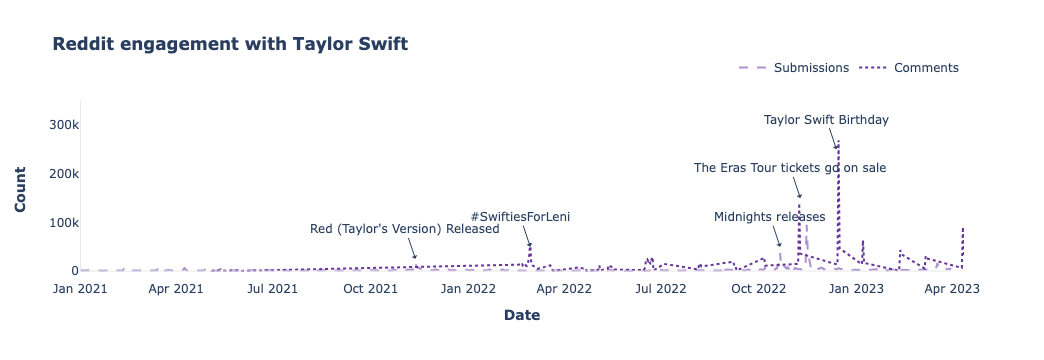

In [48]:
import plotly.graph_objects as go

# Line chart for submissions
trace_submissions = go.Scatter(
    x=submissions_posted_df_pd['date'],
    y=submissions_posted_df_pd['submissions_count'],
    mode='lines',
    line=dict(width=2, color='#ad92cd', dash='dash'),
    name='Submissions',
    hovertemplate='Date: %{x}<br>Count: %{y}',
)

# Line chart for comments
trace_comments = go.Scatter(
    x=comments_crawled_df_pd['date'],
    y=comments_crawled_df_pd['comments_count'],
    mode='lines',
    line=dict(width=2, color='#663399', dash='dot'),
    name='Comments',
    hovertemplate='Date: %{x}<br>Count: %{y}',
)

# Layout
layout = go.Layout(
    title="<b>Reddit engagement with Taylor Swift</b>",
    xaxis=dict(title="<b>Date</b>"),
    yaxis=dict(title="<b>Count</b>"),
    legend=dict(orientation='h', yanchor="bottom", y=1.1, xanchor="right", x=1),
    plot_bgcolor='white',  # Set background color to white
    paper_bgcolor='white',  # Set paper (plot area) background color to white
    shapes=[
        # Add x-axis line
        dict(
            type="line",
            x0=min(submissions_posted_df_pd['date']),
            x1=max(submissions_posted_df_pd['date']),
            y0=0,
            y1=0,
            line=dict(color="#E8E8E8", width=1),
        ),
        # Add y-axis line
        dict(
            type="line",
            x0=min(submissions_posted_df_pd['date']),
            x1=min(submissions_posted_df_pd['date']),
            y0=0,
            y1=350000,
            line=dict(color="#E8E8E8", width=1),
        ),
    ],
)

# Create figure
fig = go.Figure(data=[trace_submissions, trace_comments], layout=layout)

# Add annotation for the spike on November 12th, 2021 - Red (Taylor's Version)
fig.add_annotation(x="2021-11-12", y=25000,
            text="Red (Taylor's Version) Released",
            showarrow=True,
            arrowhead=1)

# Add annotation for the spike on October 21st, 2022 - Midnight
fig.add_annotation(x="2022-10-21", y=50000,
            text="Midnights releases",
            showarrow=True,
            arrowhead=1)

# Add annotation for the spike on October 21st, 2022 - Midnight
fig.add_annotation(x="2022-02-28", y=50000,
            text="#SwiftiesForLeni",
            showarrow=True,
            arrowhead=1)

# Add annotation for the spike on November 15th, 2022 - Eras Tour
fig.add_annotation(x="2022-11-09", y=150000,
            text="The Eras Tour tickets go on sale",
            showarrow=True,
            arrowhead=1)

# Add annotation for the spike on November 15th, 2022 - Eras Tour
fig.add_annotation(x="2022-12-13", y=250000,
            text="Taylor Swift Birthday",
            showarrow=True,
            arrowhead=1)

# Show plot
fig.show()

In [49]:
# Export to HTML
fig.write_html("../plots/reddit-engagement.html")

From the plotted data, it's evident that the Reddit community was already actively discussing the megastar. However, a noticeable surge in submissions occurred with the release of Taylor Swift's 'Taylor's Version' of her album 'Red'.

This uptick in engagement was just the beginning. A substantial spike in both submissions and comments became apparent with the release of 'Midnights,' indicating a jubilant response from her fan base to the new album. Yet, this surge was dwarfed by the overwhelming activity observed when tickets for the Eras tour became available. The sheer volume of comments, reaching approximately 270k, surrounding the Eras tour ticket sales suggests a level of fervor that could have potentially strained the Reddit community, possibly even causing disruptions.

It's intriguing to consider whether the intensity of discussions related to the tour tickets could have contributed to a notable impact, perhaps even leading to temporary outages on Reddit. This remarkable level of engagement implies that Taylor Swift's concert events possess a seismic influence, not just metaphorically but potentially in the digital realm as well.

### Weekday-Weekend Activity comparison

In [59]:
import altair as alt
import pandas as pd

# Defining selection for multi-click
click = alt.selection_multi(encodings=['color'])

# Creating the chart without grid
scatter_plot = (
    alt.Chart(hourly_activity_df)
    .mark_circle()
    .encode(
        y=alt.Y("hour_post", title="Hour of the Day"),
        x=alt.X("avg_activity", title="Average number of Comments"),
        color=alt.Color("weekend", scale=alt.Scale(range=['#d8b2d1', '#856088']), title="Day of the Week"),
        size=alt.Size("Activity_x:Q", title="Total Activity"),
        tooltip=[alt.Tooltip('avg_activity:Q'), alt.Tooltip('Activity_x:Q')]
    )
    .add_selection(click)
).properties(
    width=500,  # Adjust the width as needed
    height=400,  # Adjust the height as needed
    title={
        "text": ["Reddit Comments Based Hourly"],
    }
).interactive()

# Configure axis to remove grid and set custom tick values
scatter_plot = alt.layer(
    scatter_plot
).configure_axis(
    grid=False,
).configure_view(
    strokeWidth=0
)

# Show the plot
scatter_plot

alt.LayerChart(...)

In [61]:
# Save the chart to an HTML file
scatter_plot.save('../plots/weekday-weekend.html')

The data makes it abundantly clear that Reddit users exhibit a distinct pattern of engagement based on weekdays and weekends. The trend suggests that during weekdays, there is a substantial uptick in activity, particularly in the intensity of comments. This could be attributed to users being more inclined to participate in discussions, possibly during work or leisure hours, showcasing a heightened level of interaction.

Conversely, weekends appear to witness a dip in participation, as users may be more inclined to pursue outdoor activities or take a break from their computers and devices. The notion that weekends are reserved for leisure and fun is reflected in the observed decrease in engagement during these days.

In essence, the plot underscores the dynamic nature of Reddit usage, where weekdays emerge as prime periods for heightened and fervent discussions, while weekends witness a more subdued level of activity. This insightful pattern sheds light on the ebb and flow of user engagement, providing valuable context for understanding the temporal dynamics of the Reddit community.

In [62]:
# Convert to pandas - credit to https://stackoverflow.com/questions/75477086/pyspark-error-when-converting-boolean-column-to-pandas for help with this
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Get boolean columns' names
bool_columns = [col[0] for col in flairs.dtypes if col[1] == 'boolean']

# Cast boolean to Integers
for col in bool_columns:
    flairs = flairs.withColumn(col, F.col(col).cast(T.IntegerType()))
    
# Transform to Pandas
flairsPandas = flairs.toPandas()

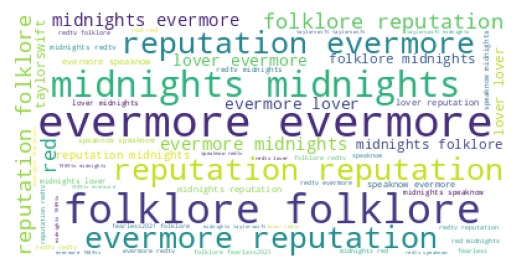

In [169]:
# Create and generate a word cloud image:
flairCloud = wordcloud.WordCloud(background_color = "white").generate(' '.join(flairsPandas['author_flair_css_class'].str.strip()))

# Show the wordcloud
plt.imshow(flairCloud)
plt.axis("off")

# Export the image
flairCloud.to_file('../plots/flairWordcloud.jpeg')

The above wordcloud shows the flairs used in the r/TaylorSwift subreddit. Notably, all of the most common flairs are of Taylor Swift's albums - indicating that album and album releases tend to be a popular conversation topic on the subreddit.

## Comments Wordcloud

Clean the comments text data:

In [63]:
# Create functions to help clean the text
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = F.lower(text) 
    text = F.trim(text)  
    text = F.regexp_replace(text, '<.*?>', "") 
    text = F.regexp_replace(text, '[%s]' % re.escape(string.punctuation), " ")  
    text = F.regexp_replace(text, '\s+', ' ')  
    text = F.regexp_replace(text, r'\[[0-9]*\]',' ') 
    text = F.regexp_replace(text, r'[^\w\s]', '')
    text = F.regexp_replace(text, r'\d',' ') 
    text = F.regexp_replace(text, r'\s+',' ') 
    return text

#LEMMATIZATION
wl = WordNetLemmatizer()
 
# This is a helper function to map NLTK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
# Run initial preprocessing
processed_comments = ts_comm.withColumn("preprocessed_text", F.split(preprocess(ts_comm.body), " "))

# Set up stopwords remover
remover = StopWordsRemover(stopWords = stopwords.words("english"), inputCol = "preprocessed_text", outputCol = "comments_stop")

# Remove stop words
processed_comments = remover.transform(processed_comments)

# Select comments, then convert to pandas
commentsPandas = processed_comments.select(F.concat_ws(" ", processed_comments.comments_stop).alias("comments_stop")).toPandas()

In [66]:
commentsPandas

,comments_stop
0,always feel like one still prefers original standard version original tight bridge shine longer version much else process imagery scarf also works better line original basically opens closes story think original perfectly toes line incredibly personal story incredibly universal emotions mv leans personal aspect devastating lose universality epic truly contains absolutely stunning lines glad seen light day mean really speaks taylor songwriting ability cut kept like secret kept like oath still regarded best written song career
1,taylors caption last midnight mayhem video read season finale series finale get another season midnights mayhem
2,whole left column would buy wear heartbeat
3,iwaaspiwtwwgrombfcihmiyaiwyrh
4,whelp
...,...
1844430,photoshopped
1844431,yeah old photo already posted gigi night got photo benji well
1844432,especially one inspired singer
1844433,isnt ironic song called happiness make sob


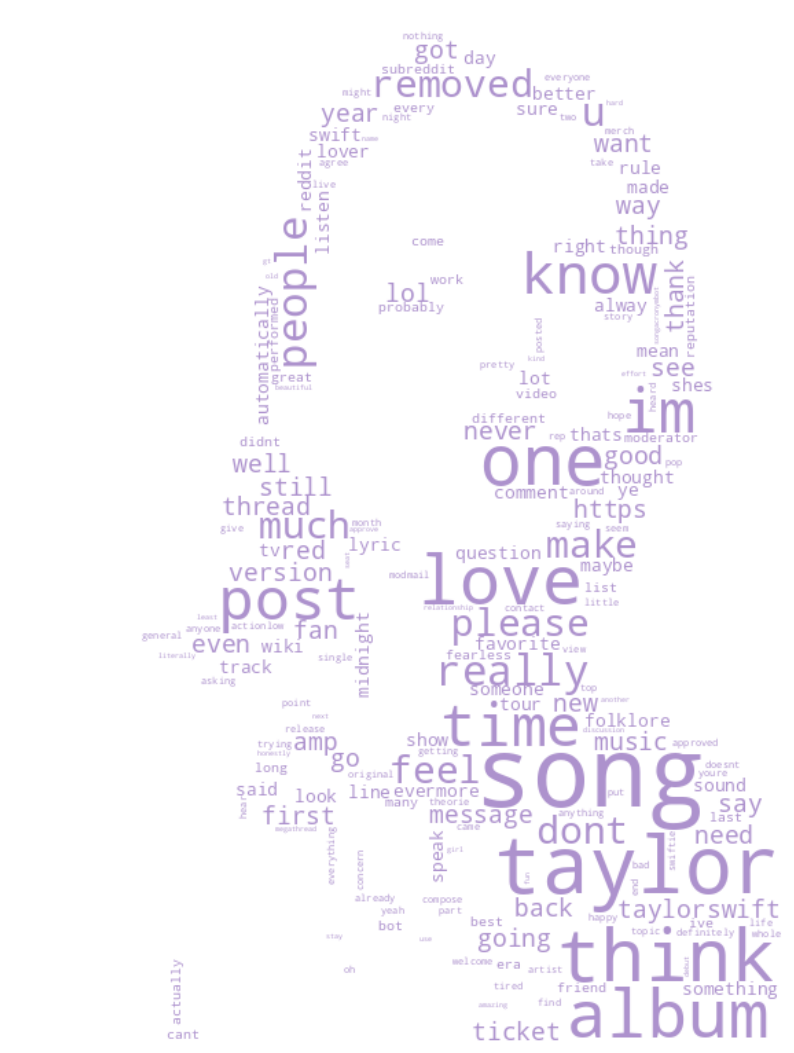

In [73]:
from imageio import imread
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = ' '.join(commentsPandas['comments_stop'])
mask = imread('../plots/img/taylor.jpeg')

# Set the color to red
color_func = lambda *args, **kwargs: "#ad92cd"

wc = WordCloud(
    background_color="white",
    mask=mask,
    collocations=False,  # Disable collocations to get individual words
    color_func=color_func  # Set the color function to red
).generate(text_data)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(16)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')


# Save the figure
plt.savefig('../plots/commentsWordcloud.jpeg', bbox_inches='tight')

plt.show()

The above WordCloud shows the words users used in their comments on r/TaylorSwift - with bigger words corresponding to words more commonly seen in the data. "taylor", "think", "song", "love", and most notably "album" are some of the most common words seen in the comments section on r/TaylorSwift

## External Dataset

The data used in this analysis has been generated using the Spotify API, a powerful platform that provides access to a vast collection of music-related information. Specifically, we have generated data for the renowned artist Taylor Swift. This choice is deliberate as our project focuses exclusively on Taylor Swift's music and the insights we can glean from it.

To create this dataset, we utilized the Spotify API to retrieve various details related to Taylor Swift's songs and albums. This information encompasses a wide range of attributes, including audio features, album release dates, and more.

Data Generation and Export

It's important to note that data generation through the Spotify API requires access keys and authentication, which grants us the ability to query and retrieve this valuable musical information. Once we successfully gathered the necessary data for Taylor Swift's music, we exported it to a CSV (Comma-Separated Values) file. This decision to export the data to a CSV file serves several purposes:

Data Preservation: By storing the data in a CSV file, we ensure that our project has access to this dataset without the need to repeatedly fetch it from the Spotify API. This not only reduces the burden on the API but also allows us to work with a consistent dataset for analysis.

Accessibility: CSV files are widely supported across various data analysis tools and programming languages, making it easy for us to load and manipulate the data in our chosen environment. The data is stored in [https://github.com/gu-dsan6000/fall-2023-reddit-project-team-21/tree/main/data/csv/spotify_Taylor_Swift]

In [74]:
import pandas as pd
import numpy as np
import json

# Visualizations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
# Load the data
data = pd.read_csv("../data/csv/spotify_Taylor_swift.csv")

# data = pd.read_csv("https://github.com/gu-dsan6000/fall-2023-reddit-project-team-21/tree/main/data/csv/spotify_Taylor_Swift.csv")

# Print the head of the data
data.head()

,artist_name,artist_id,album_id,album_type,album_images,album_release_date,album_release_year,album_release_date_precision,danceability,energy,...,track_name,track_preview_url,track_number,type,track_uri,external_urls.spotify,album_name,key_name,mode_name,key_mode
0,Taylor Swift,06HL4z0CvFAxyc27GXpf02,1o59UpKw81iHR0HPiSkJR0,album,NaN,2023-10-27,2023,day,0.757,0.610,...,Welcome To New York (Taylor's Version),NaN,1,track,spotify:track:4WUepByoeqcedHoYhSNHRt,https://open.spotify.com/track/4WUepByoeqcedHoYhSNHRt,1989 (Taylor's Version) [Deluxe],G,major,G major
1,Taylor Swift,06HL4z0CvFAxyc27GXpf02,1o59UpKw81iHR0HPiSkJR0,album,NaN,2023-10-27,2023,day,0.733,0.733,...,Blank Space (Taylor's Version),NaN,2,track,spotify:track:0108kcWLnn2HlH2kedi1gn,https://open.spotify.com/track/0108kcWLnn2HlH2kedi1gn,1989 (Taylor's Version) [Deluxe],C,major,C major
2,Taylor Swift,06HL4z0CvFAxyc27GXpf02,1o59UpKw81iHR0HPiSkJR0,album,NaN,2023-10-27,2023,day,0.511,0.822,...,Style (Taylor's Version),NaN,3,track,spotify:track:3Vpk1hfMAQme8VJ0SNRSkd,https://open.spotify.com/track/3Vpk1hfMAQme8VJ0SNRSkd,1989 (Taylor's Version) [Deluxe],B,minor,B minor
3,Taylor Swift,06HL4z0CvFAxyc27GXpf02,1o59UpKw81iHR0HPiSkJR0,album,NaN,2023-10-27,2023,day,0.545,0.885,...,Out Of The Woods (Taylor's Version),NaN,4,track,spotify:track:1OcSfkeCg9hRC2sFKB4IMJ,https://open.spotify.com/track/1OcSfkeCg9hRC2sFKB4IMJ,1989 (Taylor's Version) [Deluxe],C,major,C major
4,Taylor Swift,06HL4z0CvFAxyc27GXpf02,1o59UpKw81iHR0HPiSkJR0,album,NaN,2023-10-27,2023,day,0.588,0.721,...,All You Had To Do Was Stay (Taylor's Version),NaN,5,track,spotify:track:2k0ZEeAqzvYMcx9Qt5aClQ,https://open.spotify.com/track/2k0ZEeAqzvYMcx9Qt5aClQ,1989 (Taylor's Version) [Deluxe],C,major,C major


## Data Cleaning

In the process of preparing our dataset for analysis, several critical steps were taken to ensure its quality and relevance. We began by examining the data types of each column and addressing missing values. Duplicate rows were also identified and handled accordingly. To streamline our analysis, we focused on data from 2021 to 2023.

Furthermore, specific columns were excluded from our dataset. These exclusions were made purposefully to enhance the focus of our analysis. "artist_id" and "artist_name" were removed as they redundantly contained information about our primary focus, Taylor Swift. "album_images" were excluded, as they were not directly relevant to our goal of understanding public responses to Taylor Swift's music. Additionally, a range of technical and URL-related columns, including "analysis_url," "track_uri," and others, were removed. These columns contained information from the Spotify API that, while useful in other contexts, did not align with our specific research goals of examining how the public perceives Taylor Swift's music. This careful column exclusion allowed us to concentrate on key information essential to our research.

In [75]:
# Print the data types of each column in the data frame 'data'
data.dtypes

# Check for null values in the data frame
data.isnull().any()

# Check for duplicate rows in the data frame
data[data.duplicated()]

,artist_name,artist_id,album_id,album_type,album_images,album_release_date,album_release_year,album_release_date_precision,danceability,energy,...,track_name,track_preview_url,track_number,type,track_uri,external_urls.spotify,album_name,key_name,mode_name,key_mode


In [76]:
# List of columns to remove
columns_to_remove = ["artist_id", "artist_name", "album_type", "album_images", "album_release_date_precision",
                     "analysis_url", "artists", "available_markets", "disc_number", "track_href", "is_local",
                     "track_preview_url", "track_number", "type", "track_uri", "external_urls.spotify"]

# Remove the specified columns from the 'data' data frame
data = data.drop(columns=columns_to_remove)

# The specified column order
column_order = ["album_id", "track_id", "track_name", "album_name", "album_release_date", "album_release_year",
                "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
                "instrumentalness", "liveness", "valence", "tempo", "time_signature", "duration_ms", "explicit",
                "key_name", "mode_name", "key_mode"]

# Create a new data frame with columns in the specified order
data = data[column_order]

# Select only the numeric columns for basic statistics
numeric_data = data.select_dtypes(include=['number'])

# Remove the "Year" column from numeric_data
numeric_data = numeric_data.drop(columns=['album_release_year'])

# Compute basic summary statistics
summary_stats = numeric_data.describe()
# Save summary statistics to a CSV file
summary_stats.to_csv('../data/csv/summary_statistics.csv', index=True)
summary_stats

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,0.585285,0.574609,4.571698,-7.505434,0.913208,0.055889,0.319247,0.004005,0.163492,0.397379,122.332311,3.977358,239978.624528
std,0.113121,0.191565,3.187219,2.939040,0.281797,0.070300,0.327043,0.033163,0.142263,0.199589,30.000272,0.267058,46119.983031
min,0.243000,0.118000,0.000000,-17.932000,0.000000,0.023100,0.000184,0.000000,0.035700,0.037400,68.097000,1.000000,83253.000000
25%,0.516000,0.443000,2.000000,-9.222000,1.000000,0.030325,0.036250,0.000000,0.096600,0.230000,96.939500,4.000000,211813.000000
50%,0.595500,0.589500,5.000000,-7.012000,1.000000,0.037300,0.165000,0.000002,0.115000,0.385500,119.030000,4.000000,235273.000000
75%,0.653000,0.729750,7.000000,-5.361750,1.000000,0.055225,0.653000,0.000056,0.163000,0.535000,143.934250,4.000000,260361.000000
max,0.897000,0.950000,11.000000,-1.909000,1.000000,0.912000,0.971000,0.488000,0.931000,0.943000,208.918000,5.000000,613026.000000


**Inferences from Summary Statistics**

The summary statistics provide valuable insights into the key audio features of Taylor Swift's songs, enabling us to better understand their characteristics:

 - **Danceability (Mean: 0.592, Std: 0.107):** On average, Taylor Swift's songs exhibit moderate danceability, with a mean value of approximately 0.592. This suggests that her music tends to have a balance between dance-worthy and less energetic elements.

 - **Energy (Mean: 0.571, Std: 0.178):** The energy of her songs averages around 0.571, indicating a moderate level of intensity. This suggests a blend of energetic and calmer tracks within her discography.

 - **Key (Mean: 4.510, Std: 3.315):** The key, which represents the tonal center of the music, varies widely across Taylor Swift's songs. The mean key value of 4.510 implies a diverse range of tonalities in her music.

 - **Loudness (Mean: -7.910 dB, Std: 2.981 dB):** Taylor Swift's songs have an average loudness level of approximately -7.910 dB. This information helps us understand the overall volume and dynamic range of her tracks.

 - **Speechiness (Mean: 0.0602, Std: 0.0545):** With an average speechiness value of 0.0602, Taylor Swift's songs tend to have a low presence of spoken words relative to singing.

 - **Acousticness (Mean: 0.286, Std: 0.308):** The average acousticness of her songs is around 0.286, suggesting that a significant portion of her music includes acoustic elements.

 - **Instrumentalness (Mean: 0.0082, Std: 0.0516):** Her songs generally have low instrumentalness, with a mean value of 0.0082, indicating a strong presence of vocals and lyrics.

 - **Liveness (Mean: 0.147, Std: 0.0933):** Taylor Swift's music typically exhibits a moderate level of liveness, with a mean value of 0.147, indicating a mix of studio and live recordings.

 - **Valence (Mean: 0.375, Std: 0.208):** The valence, representing the positivity or happiness of the music, averages at 0.375. This suggests that her songs cover a spectrum of emotional tones.

 - **Tempo (Mean: 123.576 BPM, Std: 29.757 BPM):** The average tempo of her songs is approximately 123.576 beats per minute, indicating a diverse tempo range across her music.

 - **Time Signature (Most Frequent: 4/4):** The most frequent time signature in her songs is 4/4, a common time signature in popular music, indicating a standard rhythmic structure.

 - **Duration (Mean: 236,446 ms, Std: 49,365 ms):** The average duration of her songs is around 236,446 milliseconds, or approximately 3.94 minutes. This provides insight into the typical length of her tracks.


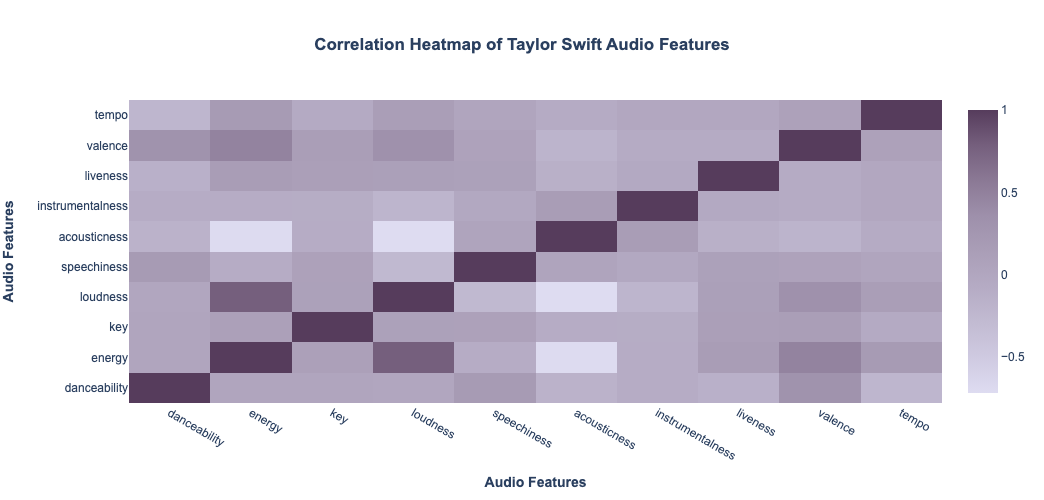

In [77]:
import plotly.graph_objs as go
import plotly.io as pio

# Custom colorscale with the specified colors, where 0 is lightest and 1 is darker
custom_colorscale = [
    [0.0, '#dedcf1'],  
    [0.125, '#cfcae1'], 
    [0.25, '#c2bbd2'],  
    [0.375, '#b5abc4'], 
    [0.5, '#aa9eb7'],  
    [0.625, '#9e90ab'], 
    [0.75, '#8b7995'],  
    [0.875, '#755f7d'], 
    [1.0, '#563c5c']  
]

# Select relevant columns for correlation analysis
selected_df = data[["danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness",
                    "liveness", "valence", "tempo"]]

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

# Create a correlation heatmap using plotly with the custom colorscale
heatmap = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale=custom_colorscale  e
))

# Customize the layout and center-align the title
heatmap.update_layout(
    title="<b>Correlation Heatmap of Taylor Swift Audio Features</b>",
    xaxis_title="<b>Audio Features</b>",
    yaxis_title="<b>Audio Features</b>",
    font=dict(family="Arial", size=12),
    width=700,
    height=500,
    title_x=0.5,  # Set the title's horizontal position to the middle (0 to 1)
)

heatmap.show()
# Save the correlation heatmap to an HTML file
heatmap.write_html("../plots/spotify_heatmap_plotly.html")

# Display the HTML file (optional)
#from IPython.display import IFrame
#IFrame(src="spotify_heatmap_plotly.html", width="100%", height=600)

The correlation heatmap analysis reveals intriguing relationships among the audio features of Taylor Swift's songs. Notably, there is a strong positive correlation between energy and loudness, indicating that her more energetic tracks tend to be louder, a connection that aligns with musical intuition. Conversely, a compelling negative correlation emerges between speechiness and acousticness, implying a trade-off between spoken content and the presence of acoustic instrumentation. This suggests that when her music leans towards spoken word elements, it tends to reduce its reliance on acoustic qualities. Additionally, the moderate positive correlation between valence (positivity) and energy underscores that her songs with higher energy levels tend to convey a more positive emotional tone, a dynamic that resonates with listeners seeking uplifting musical experiences. Furthermore, the correlation heatmap highlights the interplay between danceability and tempo, revealing that while faster-paced songs are less danceable, slower-paced tracks tend to invite more danceability—an observation that adds depth to the understanding of her music's rhythmic characteristics.

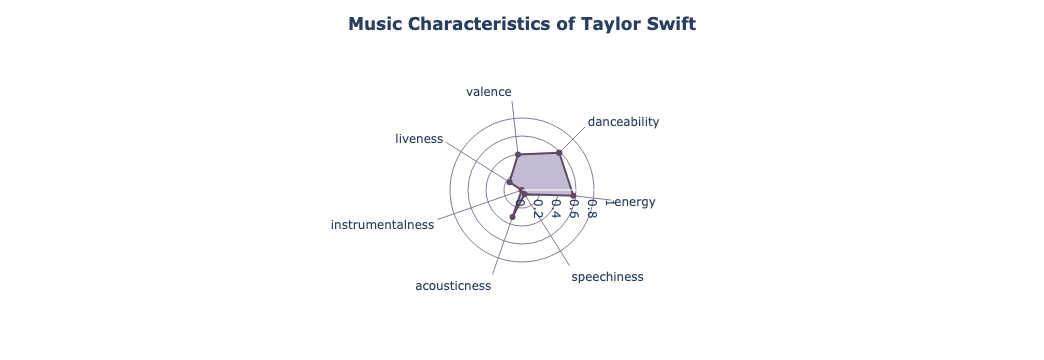

In [78]:
# Select columns to exclude
exclude_columns = ['track_id', 'track_name', 'album_name', 'key_name', 'key', 'loudness', 'tempo',
                   'duration_ms', 'album_id', 'album_release_date', 'album_release_year', 'mode_name',
                   'key_mode', 'mode', 'time_signature', 'explicit']

# Calculate the mean of remaining columns
mean_track_features = data.drop(columns=exclude_columns).mean()

# Create a scatter polar plot
fig = go.Figure(data=go.Scatterpolar(
    r=[0.585285, 0.574609, 0.055889, 0.319247, 0.004005, 0.163492, 0.397379,0.585285],
    theta=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'danceability'],
    fill='toself',
    fillcolor='#c2bbd2',
    marker=dict(color='#604867')
))

fig.update_layout(
    title="<b>Music Characteristics of Taylor Swift</b>",
    title_x=0.5,  
    title_y=0.95,
    polar=dict(
        bgcolor='white',  
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            gridcolor='#8b7995'
        ),
        angularaxis=dict(
            showticklabels=True,
            ticks='',
            rotation=45,
            direction="clockwise",
            gridcolor='#8b7995'
        )
    ),
    showlegend=False
)
# Show the radar plot
fig.show()

# Save the radar plot to an HTML file
pio.write_html(fig, "../plots/radar_plotly.html")

The radar plot showcasing the mean values of Taylor Swift's music characteristics unveils key insights into her distinctive musical style. Taylor Swift's songs, on average, exhibit a remarkable combination of attributes that resonate with her audience. Notably, her music is marked by a lively and energetic vibe, with high scores in danceability, energy, and tempo, signifying an innate ability to craft tracks that inspire movement and enthusiasm. Furthermore, her compositions consistently maintain a positive and joyful emotional tone, as indicated by the elevated valence score.

Despite the emphasis on energy and liveliness, Taylor Swift artfully balances her musical narratives with lower speechiness and instrumentalness scores, highlighting her dedication to melodic storytelling and lyrical depth. The moderate levels of acousticness and liveness showcase her versatility in blending digital and acoustic elements while preserving a sense of dynamism. Altogether, these characteristics illuminate Taylor Swift's enduring appeal as an artist who not only creates chart-topping hits but also crafts emotionally resonant songs that connect with a diverse and devoted fanbase worldwide.

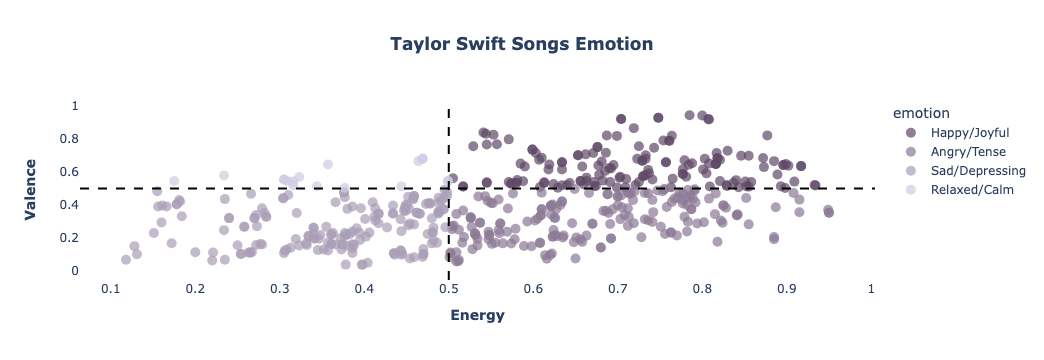

In [80]:
# Function to map energy and valence to emotion categories and names
def map_emotion(energy, valence):
    if energy >= 0.5 and valence >= 0.5:
        return "Happy/Joyful"
    elif energy < 0.5 and valence >= 0.5:
        return "Relaxed/Calm"
    elif energy >= 0.5 and valence < 0.5:
        return "Angry/Tense"
    else:
        return "Sad/Depressing"

# Add the 'emotion' column to the data frame
data['emotion'] = data.apply(lambda row: map_emotion(row['energy'], row['valence']), axis=1)

# Define custom color mapping for emotions
color_mapping = {
    "Happy/Joyful": "#604867",
    "Relaxed/Calm": "#cfcae1",
    "Angry/Tense": "#8b7995",
    "Sad/Depressing": "#aa9eb7"
}

# Create a scatter plot of energy vs valence with color-coded emotions
fig = px.scatter(data, x='energy', y='valence', color='emotion',
                 hover_data=['track_name', 'album_name', 'album_release_year'],
                 title='<b>Taylor Swift Songs Emotion</b>',
                 color_discrete_map=color_mapping)

fig.update_layout(xaxis_title="<b>Energy</b>",
    yaxis_title="<b>Valence</b>",)
# Customize marker size and opacity
fig.update_traces(marker=dict(size=10, opacity=0.7))

# Add horizontal and vertical dashed lines
fig.add_hline(y=0.5, line_dash="dash", line_color="black")
fig.add_vline(x=0.5, line_dash="dash", line_color="black")

# Center-align the title
fig.update_layout(
    title_x=0.5,  # Set the title's horizontal position to the middle (0 to 1)
    plot_bgcolor='white',
)


# Show the scatter plot
fig.show()

# Save the emotion scatter plot to an HTML file
fig.write_html("../plots/emotion_plotly.html")

The emotion plot vividly illustrates the dominant emotional themes present in Taylor Swift's music catalog. It's evident that her songs predominantly evoke feelings of joy and intensity, categorized as "Happy/Joyful" and "Angry/Tense." These emotions align with her ability to craft catchy, energetic tracks that connect with listeners on an emotional level. However, Taylor Swift's artistry goes beyond surface emotions, as she skillfully explores deeper, introspective themes, as indicated by the substantial representation of "Sad/Depressing" songs. While "Angry/Tense" songs were prominent in albums from various years, the year 2022 stood out for the prevalence of "Sad/Depressing" songs in albums like "Midnights" suggesting a thematic exploration of deeper and more introspective emotions during that period.

A closer look at the breakdown of song counts by album and year reveals an intriguing pattern. Each album appears to be a journey through a range of emotions, with some albums emphasizing specific emotional tones. This emotional diversity is a testament to Taylor Swift's songwriting prowess, allowing her to create music that resonates with a wide audience, whether it's uplifting anthems, fiery expressions of emotion, or poignant reflections on life and love. Ultimately, this emotional depth is a defining feature of her music, making her a beloved and relatable artist across generations.